2022 Rachel Banks and Soichi Hirokawa. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

# Gillespie Simulations on Kinetic Proofreading

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Example 2: Using Gillespie simulations on kinetic proofreading to understand energetic cost, speed and fidelity tradeoffs. 

In this tutorial, we will show how at the cost of hydrolyzing GTP, the ribosome can synthesize a polypeptide chain with lower errors and at a greater speed than if translation simply distinguished off-rates of the wrong tRNA.

In a previous tutorial, we showed a simple example of applying Gillespie simulations in the context of ligand-receptor binding. In that example, when a new event occured, we knew what the next state would be: if the receptor was unbound, then the receptor would become bound in the next time step, and vice versa. Gillespie simulations need not be limited to two-state systems. In this tutorial, we will use Gillespie simulations on a system that involves more than one stochastic process: kinetic proofreading. We will consider the ribosome, which uses kinetic proofreading to select for the correct amino acid over all the wrong ones. In brief, the ribosome adds amino acids to the growing peptide chain by binding a tRNA charged with an amino acid and bound to GTP. Upon GTP hydrolysis, the ribosome enters an activated state, and then the amino acid can be added to the polypeptide chain. In this process, there are a few steps that distinguish between the correct C and wrong W amino acid: binding and unbinding of the charged tRNA with the ribosome, GTP hydrolysis rate, and incorporation of the amino acid. While the ribosome  n the classic Hopfield-Ninio model of kinetic proofreading, only the unbinding rates of the correct and wrong amino acids differ. The unbinding rate of wrong amino acids is higher than for correct amino acids, meaning that wrong amino acids are more likely to unbind from the ribosome. 

**The Model** 

We will consider that the ribosome can be in five states labeled according to the diagram taken from Chen *et al.*, 2020:

0.   free (unbound)
1.   bound to the correct tRNA with GTP
2.   bound to the wrong tRNA with GTP
3.   bound to the correct tRNA with GDP
4.   bound to the wrong tRNA with GDP

These states are shown below in the diagram adapted from 

---

Chen *et al.* *The Biophysicist* 2020, 

---



---



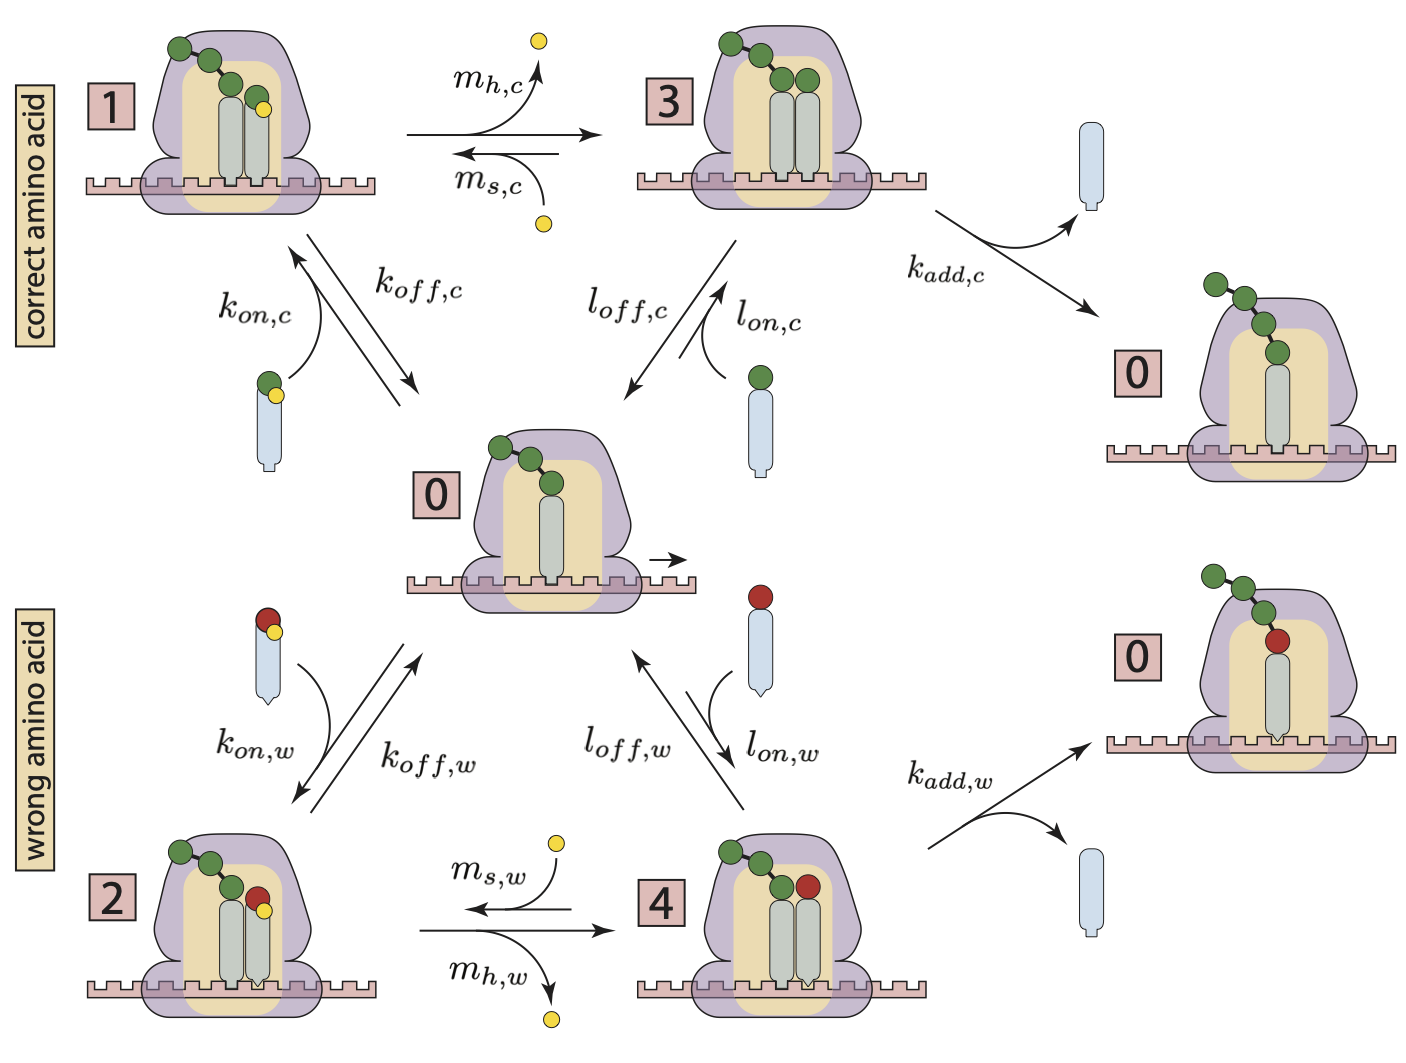

As suggested by the smaller reaction arrows for GTP hydrolysis and the binding of the GDP-bound tRNA, the ribosome favors cycles where it binds either the correct or wrong tRNA (state 1 or 2) before undergoing hydrolysis of GTP to go from states 1 and 2 to states 3 and 4, respectively. Once in this activated state, the ribosome can return to the unbound state (state 0) by either incorporating the amino acid on the tRNA to the polypepdtide chain or unbinding the tRNA without amino acid incorporation. We will perform a stochastic simulation of the ribosome going through these cycles, jumping from one state to another based on the kinetic rates that define transitions between states, as shown above. We will first examine how the equilibrium model affects the time and error rate of constructing a polypeptide consisting of $N$ amino acids and later compare the speed and fidelity to the Hopfield-Ninio model, GTP hydrolysis provides the ribosome with a second opportunity to reject the wrong tRNA before incorporating its amino acid. Both of these models follows the schematic above but differ in the relative values of different rates. Before we dive into the code, let's examine how what we have learned in the ligand-receptor case gets extended to the kinetic proofreading case.

## Extending to more than two states

In comparison to the ligand-receptor case, the kinetic proofreading system is more complicated. For one, we can see that at any given state, the ribosome has more than one state to which it can transition. In the simulation, this means that after we draw out the time that an event happens, we must also *decide* what the next state is. Furthermore, if the ribosome has hydrolyzed GTP but not yet incorporated an amino acid (states 3 or 4), it can go to the empty state (state 0) in one of two ways: it can incorporate the amino acid or the tRNA can come off without incorporation. These factors warrant additional consideration in setting up the simulation. What is the exponential waiting time distribution when there are multiple rates? How do we decide the next state of the ribosome?

### Modifying the waiting time distribution

Suppose the ribosome is in state $j$ where $j$ is one of the integers from 0 to 4 as noted in the diagram. Then in the same way that we saw with one rate in the ligand-receptor case, the probability of the ribosome transitioning from state $j$ to another state (call this state $i$) with rate $r_{ij}$ in the time interval $\Delta t$ is $P_{ij} = r_{ij} \Delta t$. Here, we have two indices where $j$ for the current state of the ribosome and $i$ is the next possible state of the ribosome. In some of these cases, $r_{ij} = 0$ during the math to mean that the ribosome cannot actually transition to a particular state. An example of this is that the ribosome in state $j$ cannot return to the same state $j$, so $r_{jj}=0$. We can instead ask what is the probability of an event not occurring in this interval, which gives us $P^\text{not}_{ij} = 1 - r_{ij} \Delta t$. Then the probability that none of these happens $P_j^\text{not}$ is the product of all $P^{not}_{ij}$ for the same value of $j$, or 
\begin{align}
P_j^\text{not} &= \prod_{i=0}^4 \left( P_{ij}^\text{not} \right),\\
&= \prod_{i=0}^4 \left( 1 - r_{ij} \Delta t \right)\tag{1},
\end{align}
where $\prod$ means the product where we input $P_{ij}^\text{not}$ with the specific numbers from 0 to 4. Similar to the derivation in the ligand-receptor case, we can instead instead change our time interval $\Delta t$ to a waiting time $t = N \Delta t$ where $N \gg 1$, so
\begin{equation}
  P_j^\text{not} = \prod_{i=0}^4 \left( 1 - r_{ij} \frac{t}{N} \right). \tag{2}
\end{equation}
If we carry out the multiplications and make the approximation that orders of $N$ larger than 2 go to 0 $\left( \frac{1}{N^2} \approx 0 \right)$ we get
\begin{align} 
P_j^\text{not} &\approx 1 - \frac{t}{N} \sum_{i=0}^4 r_{ij}. \tag{3}
\end{align}
Then if we ask what is the probability of none of these events occurring after $N$ intervals of $\Delta t$, we get
\begin{align}
  P(0 \text{ events}, t|\{r_{ij}\}_j) &= \left( 1 - \frac{t}{N} \sum_{i=0}^4 r_{ij} \right)^N,\tag{4}
\end{align}
which we can approximate as an exponential as $\frac{t \sum_i r_{ij}}{N} \ll 1$ so
\begin{align}
  P\left( 0 \text{ events}, t|\{r_{ij}\}_j \right) &= \exp \left( - \frac{t}{N} \sum_{i=0}^4 r_{ij} N \right),\\
  &= \exp \left( - \sum_{i=0}^4 r_{ij} t \right). \tag{5}
\end{align}
Here, we denote $\{r_{ij}\}_j$ as the set of all rates $r_{ij}$ with the same value $j$ to denote the current state of the ribosome. When all is said and done, we can see that when we are dealing with multiple possible transitions occurring, the rate term is effectively the sum of all of the corresponding rates. Thus, through the pseudorandom number generator to obtain a value $x$ in the range $[0,1)$, we see that 

\begin{equation}
  t = - \frac{\text{ln} \left( x \right)}{\sum_j r_j}, \tag{6}
\end{equation}

### Making decisions with $n$-sided dice

Once we know that a new event has occurred, we need to decide what the event is. In this context, we will also apply one or two more stochastic processes (a) to determine the next state of the ribosome and (b) if the ribosome goes from states 3 or 4 to state 0, to determine whether an amino acid is incorporated or not. Unlike the Poisson process of waiting for any of the events to occur, the stochastic part of this step is more like flipping a biased coin or in the case of more than two outcomes rolling a misshapen N-sided die. In the case of two possible events, we can determine the probability of one of the events occurring based on the rates:

\begin{equation}
  p_1 = \frac{r_1}{r_1 + r_2}. \tag{7}
\end{equation}

Notice here that an increase in $r_1$ indicates an ever faster rate for that transition which for fixed $r_2$ means a greater probability that the $r_1$ event is taken. We can once again use the same pseudorandom number generator and compare it against $p_1$. If the generated number $x \leq p_1$, we will say that the event corresponding to $r_1$ is taken while the event corresponding to $r_2$ is taken when $x > p_1$. As we see with the kinetic proofreading scheme, there are more than two states accessible to the ribosome so if the ribosome is in state $j$, then the probability that it transitions to state $i$, which we will write as $p_{ij}$ and not to be confused with $P_{ij}$ above, will be
\begin{equation}
p_{ij} = \frac{r_{ij}}{\sum_{i=0}^4 r_{ij}}. \tag{8}
\end{equation}
When implemented in the simulation, one can imagine each probability occupying a different region of the number line [0,1) and determining where the generated number $x$ falls within the regime. So for three possible events, the three regimes would be $[0,p_1)$ for event 1, $[p_1,p_1+p_2)$ for event 2, and $[p_1+p_2,1)$ for event 3 (as $p_1+p_2+p_3=1$). This approach can continually be applied for an arbitrary number of possible outcomes, with the sum of the rates being the normalization to generate the probabilities.

## Mathematizing the diagram

With all of this said, let's see the simulation in action. We will begin with the Hopfield-Ninio model, in which the main difference between correct and wrong tRNAs are the unbinding rates, $k_{off,c}$, $k_{off,w}$, $l_{off,c}$, and $l_{off,w}$, where the off rates for the wrong amino acid are 5 times greater than that of the correct amino acid. For this equilibrium model, we also pretend that GTP hydrolysis does not have a large free energy difference, so that GTP synthesis is still likely to occur. 

As suggested by the notation $r_{ij}$ for the rates and as it is quickly 
apparent with the fourteen different transitions across these five states, it
is more convenient to create a 5x5 matrix of these rate constants where each 
column represents the state that the ribosome is in and the rows denote the 
states to which the ribosome can transition. This set-up will also prove 
helpful as we will often need to work with the appropriate column to access 
relevant rates and probabilities. With fewer lines of code we can carry out our 
Gillespie simulation using only the column representing the state of the 
ribosome and determining where the ribosome goes next. Because we will be changing a few rates while keeping many others the same as we go through the tutorial, we will create a function to create the rates matrix while the rates 
are default argument values. That way, when we explore another model and only want to change a few of the parameters, we only need to call the rates that differ from the default values in the new model. We will also ask the function
to return $k_{add,c}$ and $k_{add,w}$ since we will use them to obtain our
probability of incorporation and want to avoid using the wrong rates as we
begin to change parameters.

In [ ]:
def construct_matrix(kon_c = 40,
                     koff_c = 0.5,
                     lon_c = 0.001,
                     loff_c = 0.085,
                     mhc = 0.01,
                     msc = 0.001,
                     kadd_c = 4.14,
                     phikon_w = 1,
                     phikoff_w = 94,
                     philon_w = 1,
                     philoff_w = 7.9,
                     phimhw = 1,
                     phimsw = 0.084,
                     phikadd_w = 1):
  """
  Constructs a matrix of the rates
  
  Inputs:
  --------
  rij : kinetic rates of the ribosome
  
  Returns:
  --------
  rates_mat : 5x5 array of the rates, columns denote current state of ribosome
  kadd_c : float, incorporation rate for the correct amino acid
  kadd_w : float, incorporation rate for the wrong amino acid
  """
  rates_mat = np.zeros((5,5))

  # define wrong rates as a factor of correct rates
  kon_w = phikon_w * kon_c
  koff_w = phikoff_w * koff_c
  lon_w = philon_w * lon_c
  loff_w = philoff_w * loff_c
  mhw = phimhw * mhc
  msw = phimsw * msc
  kadd_w = phikadd_w * kadd_c

  # [0,0] is 0
  rates_mat[1,0] = kon_c
  rates_mat[2,0] = kon_w
  rates_mat[3,0] = lon_c
  rates_mat[4,0] = lon_w

  # [1,1] [2,1] and [4,1] are all 0
  rates_mat[0,1] = koff_c
  rates_mat[3,1] = mhc

  # [1,2], [2,2], and [3,2] are all 0
  rates_mat[0,2] = koff_w
  rates_mat[4,2] = mhw

  # [2,3], [3,3], and [3,4] are all 0
  rates_mat[0,3] = loff_c + kadd_c
  rates_mat[1,3] = msc

  # [1,4], [3,4], and [4,4] are all 0
  rates_mat[0,4] = loff_w + kadd_w
  rates_mat[2,4] = msw

  return rates_mat, kadd_c, kadd_w

In [ ]:
rates_mat, kadd_c, kadd_w = construct_matrix()
print(np.round(rates_mat,4))

[[0.0000e+00 5.0000e-01 4.7000e+01 4.2250e+00 4.8115e+00]
 [4.0000e+01 0.0000e+00 0.0000e+00 1.0000e-03 0.0000e+00]
 [4.0000e+01 0.0000e+00 0.0000e+00 0.0000e+00 1.0000e-04]
 [1.0000e-03 1.0000e-02 0.0000e+00 0.0000e+00 0.0000e+00]
 [1.0000e-03 0.0000e+00 1.0000e-02 0.0000e+00 0.0000e+00]]


Now that we have defined the rates, let's walk through the simulation elements to see what else we need to set up. In this particular case, the steps of our simulation will be as follows:

1.   Determine the state that the ribosome is in (we will start the simulation with the ribosome in the unbound state, state 0).
2.   Using the transition rates accessible to the ribosome at its current state, determine the time that one of those transitions will occur.
3.   Decide which transition occurs from the probabilities of each transition.
4.   If the transition goes from state 3 or 4 to 0, decide if an amino acid was incorporated.
5.   Update the state of the ribosome.

We have essentially set up Step 2 with the rates matrix. However, we still need 
to generate the probabilities of each transition, which we defined in Eq. 8, 
for Step 3 and the incorporation probability to perform Step 4. Fortunately, we
can set up these probabilities in advance and call upon them as needed in the simulation. To perform the probabilities as outlined in Eq. 8, we can see that
the probability of a transition from $j$ to $i$ occurring, we saw that we can take the relevant rate $r_{ij}$ and normalize by the sum of all of the rates in
the same column. This means that we can take our normalizations involve summing
the rates matrix along the columns then divide each column of the rates matrix
with the matching normalization factor. Let's then apply this calculation.

In [ ]:
probs_mat = rates_mat.copy()
# sum rates along columns for normalization factors
rates_sum = np.sum(rates_mat, axis=0)

for i in range(5):
  probs_mat[:,i] = probs_mat[:,i]/rates_sum[i]
print(np.round(probs_mat,5))

[[0.0000e+00 9.8039e-01 9.9979e-01 9.9976e-01 9.9998e-01]
 [4.9999e-01 0.0000e+00 0.0000e+00 2.4000e-04 0.0000e+00]
 [4.9999e-01 0.0000e+00 0.0000e+00 0.0000e+00 2.0000e-05]
 [1.0000e-05 1.9610e-02 0.0000e+00 0.0000e+00 0.0000e+00]
 [1.0000e-05 0.0000e+00 2.1000e-04 0.0000e+00 0.0000e+00]]


If we look at the first column, which corresponds with the ribosome being in the free state (state 0), the ribosome cannot transition to state 0 because we are looking for a transition to a different state from its current one. In addition, we see that binding of tRNA-GTP to the ribosome regardless of the correct or wrong amino acid (states 1 or 2) has a probability of $\approx.5$ each. Finally, binding of tRNA-GDP (states 3 or 4) is still possible but highly
unlikely, with probabilities of $\approx 10^{-5}$. As we mentioned above, we 
will want to take the cumulative sum of the probabilities along the columns to create the bins for the random number drawing.

In [ ]:
# compute the cumulative sum along columns
probs_sum = np.cumsum(probs_mat, axis=0)
print(probs_sum)

[[0.         0.98039216 0.99978728 0.99976337 0.99998254]
 [0.4999875  0.98039216 0.99978728 1.         0.99998254]
 [0.999975   0.98039216 0.99978728 1.         1.        ]
 [0.9999875  1.         0.99978728 1.         1.        ]
 [1.         1.         1.         1.         1.        ]]


Finally, we write the probability that an amino acid is incorporated if we go from the activated ribosome state (3 or 4) to the free ribosome state. The normalization factor is just the rates corresponding to the current state (column) being 3 or 4 and the next state (row) being 0.

In [ ]:
# compute incorporation rates
probc_incorp = kadd_c / rates_mat[0,3]
probw_incorp = kadd_w / rates_mat[0,4]

Now, we are finally ready to write the main loop for the simulation. Let's perform 10,000 time steps and see how many amino acids are incorporated.

58 amino acids
fraction wrong =  0.0


Text(0, 0.5, 'number of amino acids in chain')

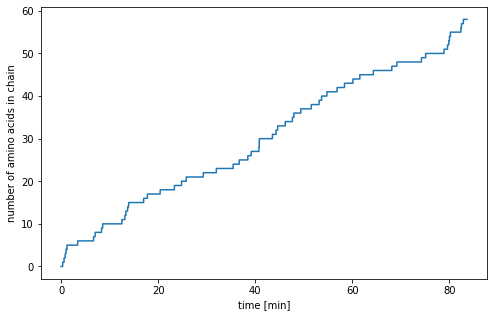

In [ ]:
# define the number of time steps
n_steps = 10000

# initially the ribosome is in state 0
current_state = 0

# empty array that transition times will go into
time = np.zeros(n_steps)
absolute_time = 0

# empty array for the amino acids incorporated, 1 for correct, 0 for wrong
amino_acids = []

# determine length of chain in time
chainlength = np.zeros(n_steps)

for i in range(n_steps):

  # we need 3 random numbers
  rand_nums = np.random.rand(3)

  # first random number determines waiting time
  ts = -np.log(rand_nums[0]) / rates_sum[current_state]
  absolute_time += ts
  time[i] = absolute_time

  # second random number determines next state
  next_state = np.nonzero(probs_sum[:,current_state] > rand_nums[1])[0][0]

  # if we go from 3-->0 or 4-->0, third number determines whether AA is incorporated
  if current_state==3 and next_state==0:
    if rand_nums[2] < probc_incorp:
      amino_acids = np.append(amino_acids, 1)

  if current_state==4 and next_state==0:
    if rand_nums[2] < probw_incorp:
      amino_acids = np.append(amino_acids, 0)
  current_state = next_state

  chainlength[i] = len(amino_acids)

# print length and error fraction of chain
num_wrong = len(amino_acids) - np.sum(amino_acids)
print(len(amino_acids), 'amino acids')
print('fraction wrong = ', num_wrong / len(amino_acids))

# plot chain against time
fig, ax = plt.subplots(1, 1, figsize=(8,5))
ax.plot(time / 60, chainlength)
ax.set_xlabel('time [min]')
ax.set_ylabel('number of amino acids in chain')

We can see that even with 10000 transitions, we incorporate fewer than 100 amino
acids. Let's alter the simulation so that we keep going until we've assembled a typical protein of 300 amino acids in size. In addition to the number of wrong amino acids incorporated, we will also look at (A) the net GTP hydrolyzed (the number of times we go from state 1 to state 3 or state 2 to state 4 minus the times we go from state 3 to state 1 or state 4 to state 2) before an amino acid is incorporated; and (B) how many times the wrong tRNA comes off of the ribosome without the incorporation of the amino acid (from states 2 or 4 to state 0) before an amino acid (correct or wrong) is incorporated. In the case of rejections, we will reset the counter to 0 every time a new amino acid is incorporated to visual how the number of rejections scales with time between incorporations. 
Rather than repeatedly write out every line of our simulation, let's put our simulation into a function where the inputs are the rate matrix, the rates of incorporating the correct and wrong amino acids, and the desired polypeptide chain length. In addition to the printed statements used above, we will
also output the GTP hydrolysis and rejection of wrong tRNAs in time.

In [ ]:
def ribosome_simulation(rates_mat, kadd_c, kadd_w, max_chainlength):

    probc_incorp = kadd_c / rates_mat[0,3]
    probw_incorp = kadd_w / rates_mat[0,4]

    rates_sum = np.sum(rates_mat, axis=0)

    probs_mat = rates_mat.copy()
    for i in range(5):
        probs_mat[:,i] = probs_mat[:,i] / rates_sum[i]

    #we will now cumulatively sum along columns so that we can choose a number between 0 to 1 to determine which transition happens 
    probs_sum = np.cumsum(probs_mat, axis=0)

    chainlength = []

    # no defined number of time steps
    # initially the ribosome is in state 0
    current_state = 0
    # states array will hold the state of the ribosome

    # rather than keep transition times, we will compile the absolute time when events occur
    time = []
    absolute_time = 0
    amino_acids = []

    # Keep count of rejections for every ribosome with the wrong tRNA 
    # that returns to the free ribosome without amino acid incorporation.
    rejections = 0
    rejection_list = []

    # Keep track of each time GTP is hydrolyzed.
    hydrolysis_count = 0

    while len(amino_acids) < max_chainlength:

        # we need 3 random numbers
        rand_nums = np.random.rand(3)

        # first random number determines waiting time
        ts = -np.log(rand_nums[0]) / rates_sum[current_state]
        absolute_time += ts
        time = np.append(time, absolute_time)

        # second random number determines next state
        next_state = np.nonzero(probs_sum[:,current_state] > rand_nums[1])[0][0]

        # if we go from 1-->3 or 2-->4, add another unit of hydrolysis
        if (current_state==1 and next_state==3) or (current_state==2 and next_state==4):
            hydrolysis_count += 1

        # if we go from 3-->1 or 4-->2, subtract a unit of hydrolysis
        if (current_state==3 and next_state==1) or (current_state==4 and next_state==2):
            hydrolysis_count -= 1

        # if we go from 3-->0 or 4-->0, third number determines whether AA is incorporated
        if current_state==3 and next_state==0:
          if rand_nums[2] < probc_incorp:
            amino_acids += [1]
            rejections = 0

        if current_state==4 and next_state==0:
          if rand_nums[2] < probw_incorp:
            amino_acids += [0]
            rejections = 0
          else:
            rejections += 1
        
        if current_state==2 and next_state==0:
          rejections += 1

        current_state = next_state

        chainlength += [len(amino_acids)]
        rejection_list += [rejections]

    # compute incorporation speed
    aa_per_sec = max_chainlength / time[-1]

    # compute the error fraction
    num_wrong = max_chainlength - np.sum(amino_acids)
    f_wrong = num_wrong / max_chainlength

    # plot rejections against time
    plt.step(time / 60, rejection_list, color='dodgerblue')

    plt.xlabel('time [min]')
    plt.title('number of rejected wrong tRNA')

    print('amino acids incorporated at ', aa_per_sec, ' aa/s')
    print('fraction of errors = ', f_wrong)
    print(hydrolysis_count / absolute_time, ' GTP hydrolyzed/s')

    return

Let's now run our code to produce a 300-amino acid long chain.

amino acids incorporated at  0.009227620055175146  aa/s
fraction of errors =  0.016666666666666666
0.0093814137227614  GTP hydrolyzed/s


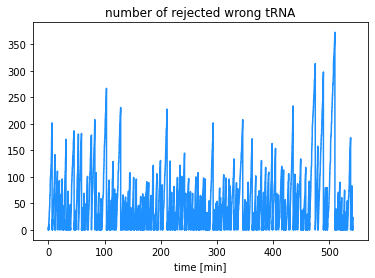

In [ ]:
# set the polypeptide chain length
max_chainlength = 300
ribosome_simulation(rates_mat, kadd_c, kadd_w, max_chainlength)

We can see in the simulation that by trying to reduce the errors in our chain,
it takes hours to synthesize our 
protein! Here, we see that the amino acid incorporation speed is on the order 
of $\backsim10^{-2}$ aa/s. This is much slower than the $\approx 0.25-8$ aa/
s measured from *in vitro* studies. One reason for the long synthesis time is
that the ribosome spends a lot of time rejecting the wrong tRNA, typically 
between 50-100 times before it incorporates an amino acid and sometimes even as
much as 250 times! And even when trying to reduce errors in our protein, we 
still see error rates of $1-2\%$. That can lead to an entirely different 
outcome in function for the protein, if there still is one.

Below is a table of the rates used to describe the Hopfield-Ninio model above,
with the middle column showing the correct tRNA rates and the last column
showing the wrong tRNA rates as a multiplicative factor of the correct tRNA
rates.

| HN Rate (s$^{-1}$)  | Correct | Wrong |
| :-- | :-: | :--: |
| $k_{on}$ | $40$ | $k_{on,c}$ |
| $k_{off}$ | $0.5$ | $94 k_{off,c}$ |
| $l_{on}$ | $0.001$ | $l_{on,c}$ |
| $l_{off}$ | $0.085$ | $7.9 l_{off,c}$ |
| $m_{h}$ | $0.01$ | $m_{h,c}$ |
| $m_{s}$ | $0.001$ | $m_{s,c}$ |
| $k_{add}$ | $4.14$ | $k_{add,c}$ |

Let's see if we can reduce the fraction of errors if we also change the on rates
of the wrong tRNA compared to their corresponding correct tRNA rates so that we
get fewer errors. This will mean that we will change $k_{on,w}$ and $l_{on,w}$,
and we will also make $k_{add,w}$ smaller as well.

amino acids incorporated at  0.009003678036139665  aa/s
fraction of errors =  0.0
0.009273788377223856  GTP hydrolyzed/s


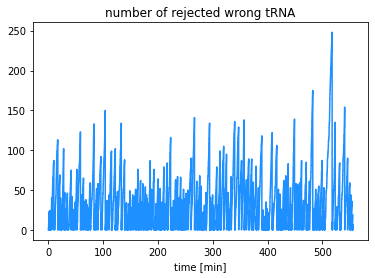

In [ ]:
# state the max_chainlength
max_chainlength = 300

# Make the wrong tRNA harder to bind
rates_mat, kadd_c, kadd_w = construct_matrix(phikon_w = 0.68,
                                             philon_w = 0.0027,
                                             phikadd_w = 0.017)

ribosome_simulation(rates_mat, kadd_c, kadd_w, max_chainlength)

Sure enough, by making it more difficult for the wrong tRNA to bind to the
ribosome, we reduce the fraction of wrong tRNAs incorporated. However, it
still takes hours to assemble our protein as the wrong tRNA still binds quite
a bit to the ribosome, so we are having to reject many of the wrong tRNAs still.

As it turns out, the rate of GTP hydrolysis is much higher than we have been
using by several orders of magnitude, with the rate of hydrolysis measured at
25 s$^{-1}$ by Zaher and Green (2010). Let's use this information and further 
alter our simulation to include the distinction between on rates *and* the
faster hydrolysis rates to reflect more realistic transition rates for the
ribosome.

amino acids incorporated at  2.635141765761773  aa/s
fraction of errors =  0.0
2.7844664658216067  GTP hydrolyzed/s


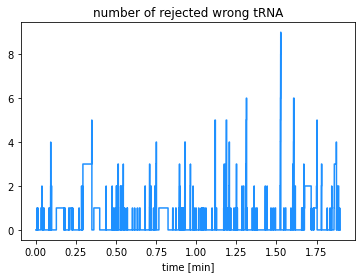

In [ ]:
# state the max_chainlength
max_chainlength = 300

# Make the wrong tRNA harder to bind
rates_mat, kadd_c, kadd_w = construct_matrix(mhc = 25,
                                             phikon_w = 0.68,
                                             philon_w = 0.0027,
                                             phimhw = 0.048,
                                             phimsw = 1,
                                             phikadd_w = 0.017)

ribosome_simulation(rates_mat, kadd_c, kadd_w, max_chainlength)

As evident by the dramatic reduction in rejections per amino acid incorporation,
we notice that by undergoing a faster GTP hydrolysis rate, the ribosome
cycles through the wrong tRNA fewer and passes through the correct tRNA for
more incorporation opportunities. This payment of GTP leads to a drastically faster protein
synthesis rate where amino acids are incorporated at a few amino acids per second, matching the expected incorporation rate.
In combination with the higher off rates and
lower on rates for the wrong tRNA as compared to those of the correct tRNA, we see that errors become incredibly rare.